# Binarization

## 1. Prerequisites

### 1. Load images

Here, we load all the image of the dataset to simply the toturial, commodly you load just the images you want process one after the other.

In [1]:
from openalea.phenomenal.data import plant_1_images

raw_images = plant_1_images()

### 1.3. Display images 

You can view each image according to this date and angle of view like this :
Note : Angle top view is represented by negative number (-1)

<IPython.core.display.Javascript object>


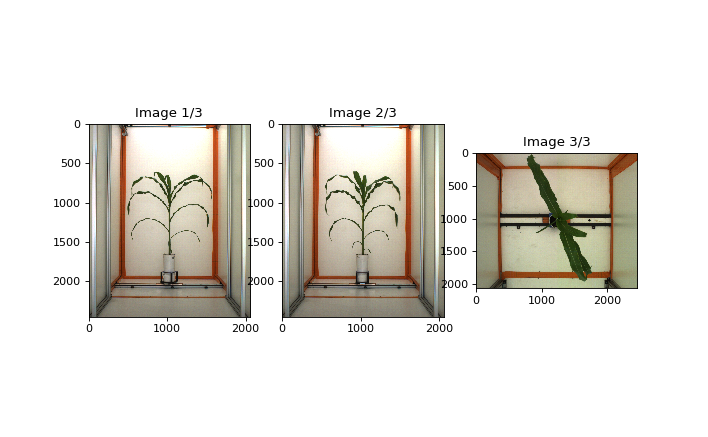

In [2]:
%matplotlib notebook

from openalea.phenomenal.display import show_images

show_images([raw_images['side'][120],
             raw_images['side'][90],
             raw_images['top'][0]])

## 2. Binarization

### 2.1. Define a binarization routines

In [3]:
import cv2

from openalea.phenomenal.data.plant_1 import(
    plant_1_mask_meanshift, 
    plant_1_mask_hsv, 
    plant_1_mask_clean_noise)

from openalea.phenomenal.image import (
    erode_dilate, 
    dilate_erode,
    close,
    threshold_meanshift,
    threshold_hsv)

def routine_side_binarization(image, mean_img):

    threshold = 0.3
    dark_background = False

    hsv_min = (30, 11, 0)
    hsv_max = (129, 254, 141)
    mask_mean_shift = plant_1_mask_meanshift()
    mask_hsv = plant_1_mask_hsv()
    mask_clean_noise = plant_1_mask_clean_noise()
    
    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Threshold the image with HSV min and max value
    binary_hsv_image = threshold_hsv(hsv_image, hsv_min, hsv_max, mask_hsv)
    
    # Threshold the image with difference between image and mean_image
    binary_mean_shift_image = threshold_meanshift(
        image, mean_img, threshold, dark_background, mask_mean_shift)
    
    # Add the two image
    result = cv2.add(binary_hsv_image, binary_mean_shift_image * 255)

    # Erode and dilate the image to remove possible noise
    result = erode_dilate(result, iterations=3, mask=mask_clean_noise)
    result = erode_dilate(result, iterations=1)
    
    return result


def routine_top_binarization(image):
    hsv_min = (42, 75, 28)
    hsv_max = (80, 250, 134)
    median_blur_size=9
    iterations=5
    
    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Apply a median blur on the image
    hsv_image = cv2.medianBlur(hsv_image, ksize=median_blur_size)

    # Threshold the image with HSV min and max value
    bin_img = threshold_hsv(hsv_image, hsv_min, hsv_max)
    # dilate and erode the image to remove possible noise
    bin_img = dilate_erode(bin_img, kernel_shape=(3, 3),iterations=iterations)

    return bin_img

### 2.2. Binarize images

In [4]:
import collections
from openalea.phenomenal.image import mean_image

# Compute the mean image of the side view image
mean_img = mean_image(raw_images['side'].values())

routine_binarization = {
    'side': lambda im : routine_side_binarization(im, mean_img),
    'top': lambda im : routine_top_binarization(im)}

bin_images = collections.defaultdict(dict)
for id_camera in raw_images:
    for angle in raw_images[id_camera]:
        bin_images[id_camera][angle] = routine_binarization[id_camera](raw_images[id_camera][angle])
             

### 2.3. Display images binarize 

<IPython.core.display.Javascript object>


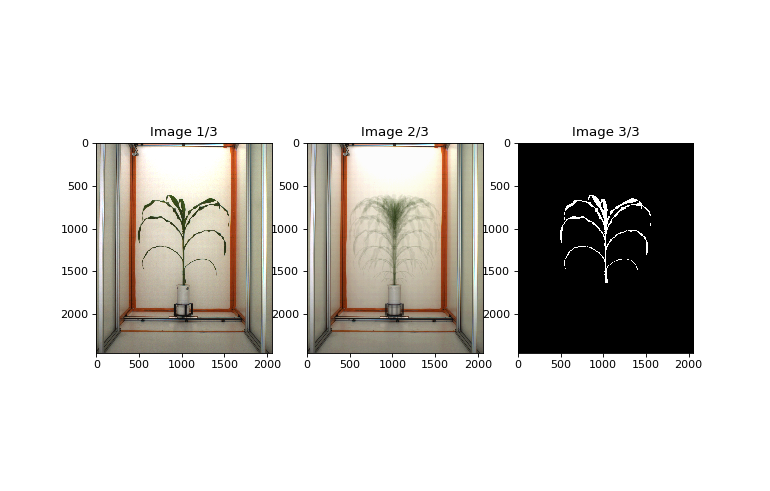

In [5]:
%matplotlib notebook

show_images([raw_images['side'][120], mean_img, bin_images['side'][120]])

<IPython.core.display.Javascript object>


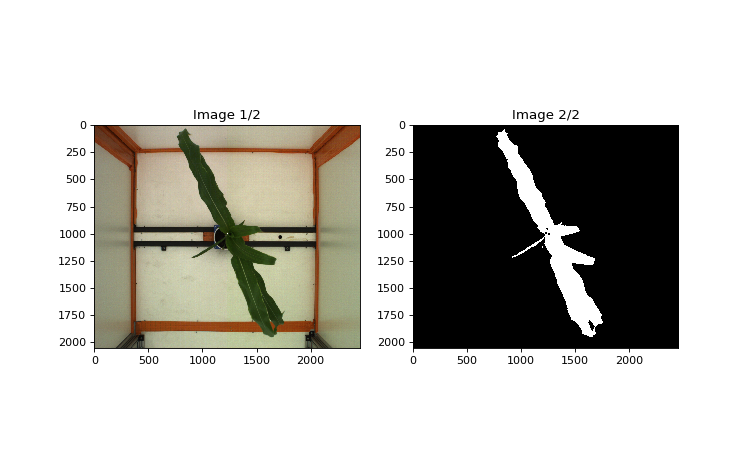

In [6]:
%matplotlib notebook

show_images([raw_images['top'][0], bin_images['top'][0]])